In [205]:
import pandas as pd
xls = pd.ExcelFile('POS_Data_SM.xlsx')
# POS_Data = pd.read_excel(xls, 'POS Data')
Barcodes = pd.read_excel(xls, 'Barcodes')
POS_Data = pd.read_csv('POS_DATA_DATE.csv')
Categories_Hierarchy = pd.read_excel(xls, 'Categories Hierarchy')
joined_table = pd.merge(POS_Data,Barcodes, how='inner', on='Barcode')
# here we join all the tables
all_joined_table = pd.merge(joined_table,Categories_Hierarchy, how='inner', on=['CategoryA','CategoryB','CategoryC','CategoryD'])
# we clean some values
all_joined_table.drop(179817,axis=0,inplace=True)

# we groupby by CategoryC and aggregate its size in the column counts
all_joined_table_groupedby_categoryC = all_joined_table.groupby(["CategoryC"]).size().reset_index(name='counts')
# we sort descending by counts
sorted_categories = all_joined_table_groupedby_categoryC.sort_values(by="counts",ascending=False)
# sorted_categories

In [175]:
# we get rid of data we do not need 
Categories_Hierarchy_dropped_catD = Categories_Hierarchy.drop(['CategoryD','CategoryDDescription'],axis=1)
Categories_Hierarchy_dropped_catD = Categories_Hierarchy_dropped_catD.groupby(['CategoryC','CategoryCDescription']).size()
Categories_Hierarchy_dropped_catD = Categories_Hierarchy_dropped_catD.to_frame().reset_index()
Categories_Hierarchy_dropped_catD.drop(0, axis=1, inplace=True)
# we merge with categories hierarchy table to get the description of each category
sorted_categories_with_description = pd.merge(sorted_categories,Categories_Hierarchy_dropped_catD,how='inner', on="CategoryC" )

def size(x):
    x = int(x)
    return x/235323
sorted_categories_with_description['counts%'] = 'counts%'
# we calculate the percentage of counts for each category by diving the number of overall barcode data
sorted_categories_with_description['counts%'] = sorted_categories_with_description['counts'].map(size)
# we get the top 10
sorted_categories_with_description_top_10 = sorted_categories_with_description[:10]
sorted_categories_with_description_top_10

,CategoryC,counts,CategoryCDescription,counts%
0,183,22004,ΦΡΕΣΚΑ ΛΑΧΑΝΙΚΑ,0.093506
1,8,15093,ΓΑΛΑ ΦΡΕΣΚΟ,0.064137
2,261,12017,ΑΝΑΨΥΚΤΙΚΑ,0.051066
3,284,9007,ΧΑΡΤΙΚΑ,0.038275
4,110,7712,ΤΥΡΙΑ ΚΟΥΠ,0.032772
5,181,7407,ΦΡΕΣΚΑ ΦΡΟΥΤΑ,0.031476
6,285,5153,ΕΙΔΗ ΥΓΙΕΙΝΗΣ - ΚΑΛΛΥΝΤΙΚ,0.021898
7,282,5105,ΚΑΘΑΡΙΣΤΙΚΑ,0.021694
8,229,5089,ΤΣΙΠΣ/ΣΝΑΚΣ,0.021626
9,1,4837,ΓΙΑΟΥΡΤΙ,0.020555


In [235]:
# we calculate the sum_units for each C category
# we calculate the sum_units for each unique combinaton of basket_id and C category
basket_id_and_catC_sum_units = all_joined_table.groupby(['Basket_ID','CategoryC'])['Sum_Units'].sum().reset_index()


In [223]:
# we calculate the total sum of each basket_id
sum_units_per_basket_id = all_joined_table.groupby('Basket_ID')['Sum_Units'].sum().reset_index()
sum_units_per_basket_id.columns = ['Basket_ID', 'Basket_Sum']


In [53]:
# we join the tables with the total basket unit sum and the table with
# each category and basket_id sum combination
sumUnits_df_merged = pd.merge(basket_id_and_catC_sum_units,sum_units_per_basket_id,how='inner',on="Basket_ID")
sumUnits_df = sumUnits_df_merged
sumUnits_df['sum%'] = 'sum%'
sumUnits_df
# to calculate the percentage of each C category item of the total sum of each basket we
# divide the sum_units of the C category and basket_id combination with the total basket_id sum
sumUnits_df['sum%'] = sumUnits_df['Sum_Units'] / sumUnits_df['Basket_Sum']
sumUnits_df
# we groupby by each C category and calculate the mean for each sum% of each C category
sumUnits_df = sumUnits_df.groupby(['CategoryC'])['sum%'].mean().reset_index()
sumUnits_df.columns = ['CategoryC', 'Average % unit per basket']
# sumUnits_df.sort_values('Average % unit per basket',ascending=False)


In [180]:
# here we calculate the average unit for each C category per basket
average_pCategory = sumUnits_df_merged.groupby(['CategoryC'])['Sum_Units'].mean().reset_index()
average_pCategory.columns = ['CategoryC', 'Average unit per basket']
# average_pCategory.sort_values('Average unit per basket',ascending=False)


In [55]:
# here we calculate the sum value for each combination of basket_id and C category
sum_value_combo = all_joined_table.groupby(['Basket_ID','CategoryC'])['Sum_Value'].sum().reset_index()


In [224]:
# total sum value for each basket_id
sum_units_pBasket = all_joined_table.groupby('Basket_ID')['Sum_Value'].sum().reset_index()
sum_units_pBasket.columns = ['Basket_ID', 'Basket_Sum_Value']


In [57]:
# we join the tables for the total sum for each basket and the table with the sum value
# per each combination of basket_id and C category
sum_value_total_merged = pd.merge(sum_value_combo,sum_units_pBasket,how='inner',on="Basket_ID")
sum_value_total = sum_value_total_merged
sum_value_total['sum%'] = 'sum%'
sum_value_total['sum%'] = sum_value_total['Sum_Value'] / sum_value_total['Basket_Sum_Value']
# we groupby by each C category and calculate the mean for each sum% of each C category
sum_value_total = sum_value_total.groupby(['CategoryC'])['sum%'].mean().reset_index()
sum_value_total.columns = ['CategoryC', 'Average % value per basket']
# sum_value_total.sort_values('Average % value per basket',ascending=False)


In [225]:
# here we calculate the average value for each C category per basket
average_value_pCategory = sum_value_total_merged.groupby(['CategoryC'])['Sum_Value'].mean().reset_index()
average_value_pCategory.columns = ['CategoryC', 'Average value per basket']
# average_value_pCategory.sort_values('Average value per basket',ascending=False)


In [222]:
# we join all the above tables into one
table_merged_with_average = pd.merge(sorted_categories_with_description_top_10,sumUnits_df,how='inner',on="CategoryC")
table_merged_with_average = pd.merge(table_merged_with_average,average_pCategory,how='inner',on="CategoryC")
table_merged_with_average = pd.merge(table_merged_with_average,sum_value_total,how='inner',on="CategoryC")
table_merged_with_average = pd.merge(table_merged_with_average,average_value_pCategory,how='inner',on="CategoryC")


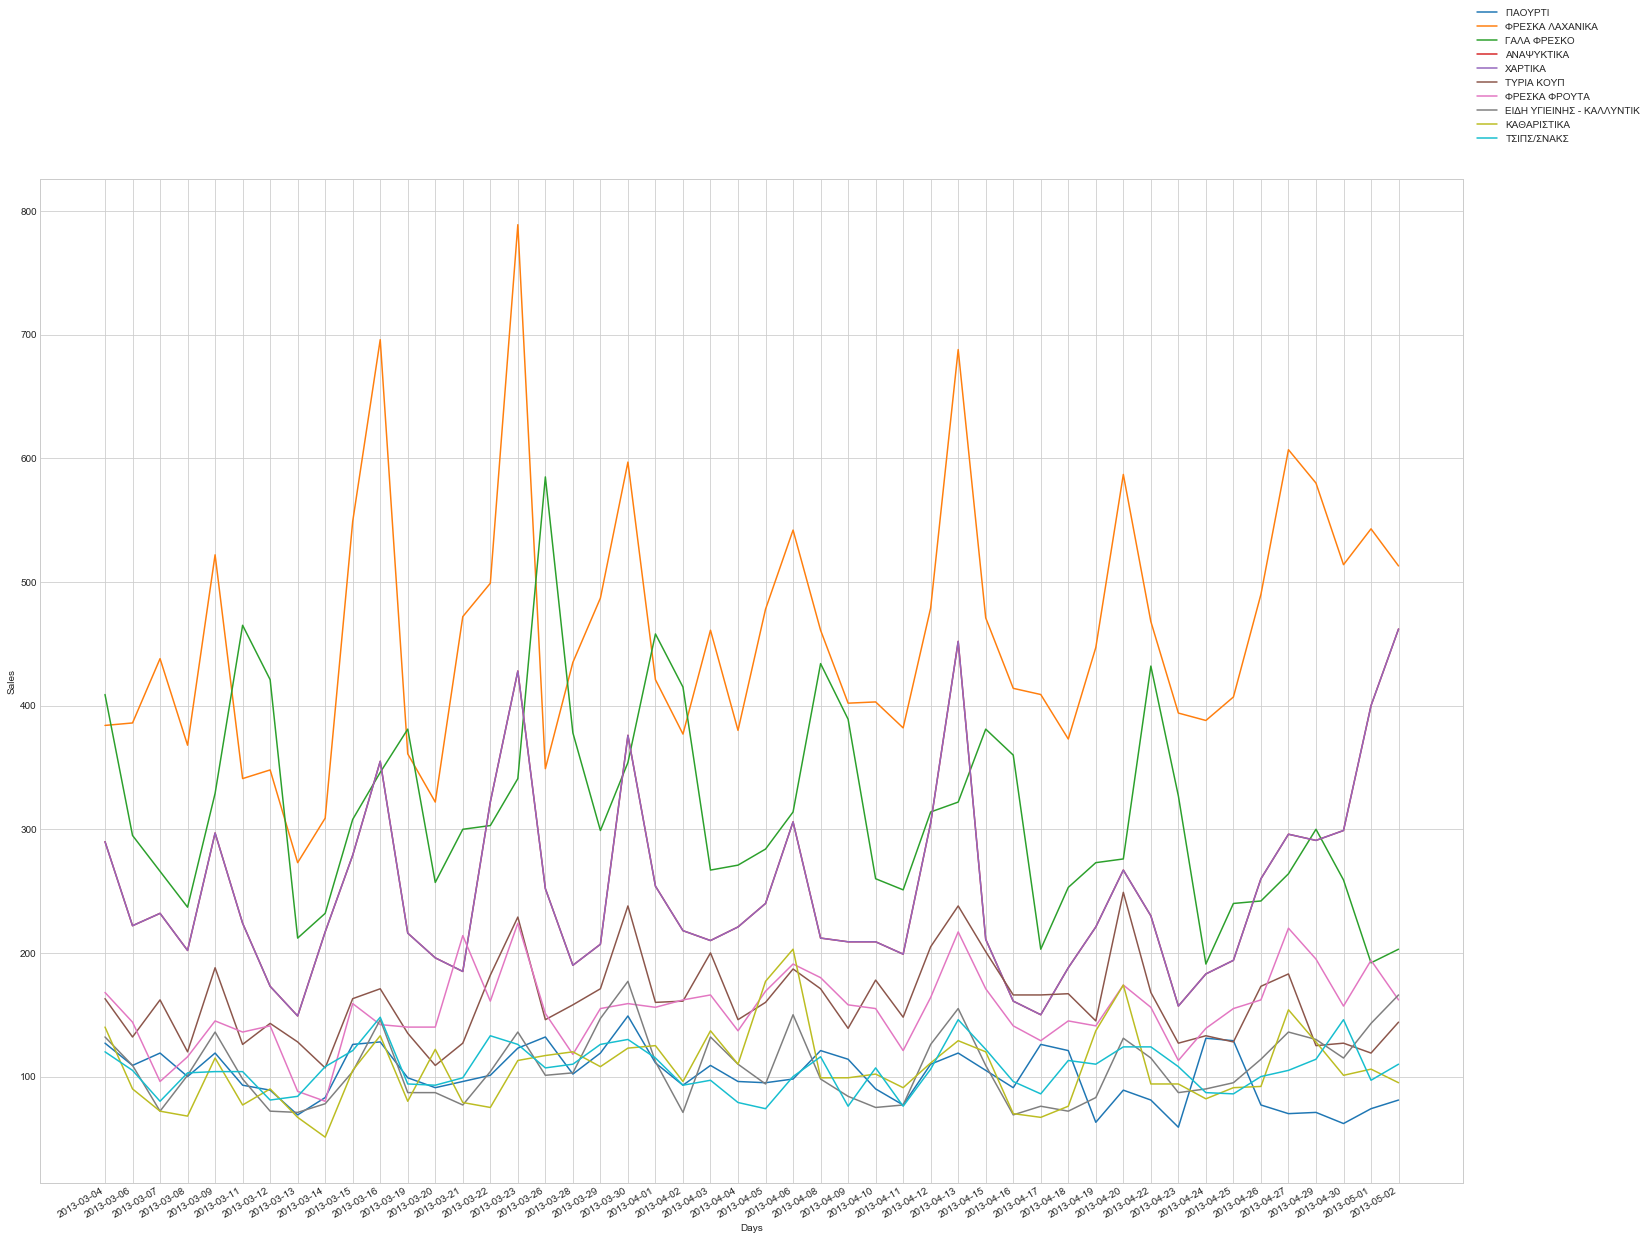

In [231]:
import matplotlib.pyplot as plt
# here we calculate the daily sales per category
categories_dates = all_joined_table.groupby(['Date','CategoryC']).size().reset_index(name='day_sales')
# we join the above tables
daysales = pd.merge(categories_dates,sorted_categories_with_description_top_10,how="right",on="CategoryC")
# here we extract the daily sales for each C category
daysales1 = daysales[daysales.CategoryC==1]
daysales183 = daysales[daysales.CategoryC==183]
daysales8 = daysales[daysales.CategoryC==8]
daysales261 = daysales[daysales.CategoryC==261]
daysales284 = daysales[daysales.CategoryC==284]
daysales110 = daysales[daysales.CategoryC==110]
daysales181 = daysales[daysales.CategoryC==181]
daysales285 = daysales[daysales.CategoryC==285]
daysales282 = daysales[daysales.CategoryC==282]
daysales229 = daysales[daysales.CategoryC==229]

fig, ax = plt.subplots()
fig.autofmt_xdate()
fig.set_size_inches(25.5, 20.5, forward=True)
# we then plot a graph with the daily sales data for each C category
a = plt.plot(daysales1.Date,daysales1.day_sales, label='ΓΙΑΟΥΡΤΙ')
b = plt.plot(daysales1.Date,daysales183.day_sales, label='ΦΡΕΣΚΑ ΛΑΧΑΝΙΚΑ')
c = plt.plot(daysales1.Date,daysales8.day_sales, label='ΓΑΛΑ ΦΡΕΣΚΟ')
d = plt.plot(daysales1.Date,daysales261.day_sales, label='ΑΝΑΨΥΚΤΙΚΑ')
e = plt.plot(daysales1.Date,daysales261.day_sales, label='ΧΑΡΤΙΚΑ')
f = plt.plot(daysales1.Date,daysales110.day_sales, label='ΤΥΡΙΑ ΚΟΥΠ')
g = plt.plot(daysales1.Date,daysales181.day_sales, label='ΦΡΕΣΚΑ ΦΡΟΥΤΑ')
h = plt.plot(daysales1.Date,daysales285.day_sales, label='ΕΙΔΗ ΥΓΙΕΙΝΗΣ - ΚΑΛΛΥΝΤΙΚ')
i = plt.plot(daysales1.Date,daysales282.day_sales, label='ΚΑΘΑΡΙΣΤΙΚΑ')
j = plt.plot(daysales1.Date,daysales229.day_sales, label='ΤΣΙΠΣ/ΣΝΑΚΣ')

plt.xlabel('Days')
plt.ylabel('Sales')
fig.legend()

plt.show()

In [234]:
# here we insert a column that we will fill later
table_merged_with_average['Average Sales'] = 'Sale'
# we fill the Average Sales column with the mean daily sales of each category
table_merged_with_average.loc[table_merged_with_average['CategoryC'] == 1,['Average Sales']] = daysales1['day_sales'].mean()
table_merged_with_average.loc[table_merged_with_average['CategoryC'] == 183,['Average Sales']] = daysales183['day_sales'].mean()
table_merged_with_average.loc[table_merged_with_average['CategoryC'] == 8,['Average Sales']] = daysales8['day_sales'].mean()
table_merged_with_average.loc[table_merged_with_average['CategoryC'] == 261,['Average Sales']] = daysales261['day_sales'].mean()
table_merged_with_average.loc[table_merged_with_average['CategoryC'] == 284,['Average Sales']] = daysales284['day_sales'].mean()
table_merged_with_average.loc[table_merged_with_average['CategoryC'] == 110,['Average Sales']] = daysales110['day_sales'].mean()
table_merged_with_average.loc[table_merged_with_average['CategoryC'] == 181,['Average Sales']] = daysales181['day_sales'].mean()
table_merged_with_average.loc[table_merged_with_average['CategoryC'] == 285,['Average Sales']] = daysales285['day_sales'].mean()
table_merged_with_average.loc[table_merged_with_average['CategoryC'] == 282,['Average Sales']] = daysales282['day_sales'].mean()
table_merged_with_average.loc[table_merged_with_average['CategoryC'] == 229,['Average Sales']] = daysales229['day_sales'].mean()
table_merged_with_average
# table_merged_with_average

,CategoryC,counts,CategoryCDescription,counts%,Average % unit per basket,Average unit per basket,Average % value per basket,Average value per basket,Average Sales
0,183,22004,ΦΡΕΣΚΑ ΛΑΧΑΝΙΚΑ,0.093506,0.318247,2.066829,0.254443,29055.795040,458.417
1,8,15093,ΓΑΛΑ ΦΡΕΣΚΟ,0.064137,0.337635,1.956428,0.305245,30620.506934,314.438
2,261,12017,ΑΝΑΨΥΚΤΙΚΑ,0.051066,0.292588,1.912905,0.249124,19156.820210,250.354
3,284,9007,ΧΑΡΤΙΚΑ,0.038275,0.280084,1.605513,0.332863,31080.644781,187.646
4,110,7712,ΤΥΡΙΑ ΚΟΥΠ,0.032772,0.208619,1.279219,0.308582,27760.973130,160.667
5,181,7407,ΦΡΕΣΚΑ ΦΡΟΥΤΑ,0.031476,0.238085,1.336459,0.242320,13054.630649,154.312
6,285,5153,ΕΙΔΗ ΥΓΙΕΙΝΗΣ - ΚΑΛΛΥΝΤΙΚ,0.021898,0.243774,1.494358,0.271957,14133.013827,107.354
7,282,5105,ΚΑΘΑΡΙΣΤΙΚΑ,0.021694,0.221191,1.494029,0.224000,10344.817115,106.354
8,229,5089,ΤΣΙΠΣ/ΣΝΑΚΣ,0.021626,0.266871,1.659570,0.225315,6164.912752,106.021
9,1,4837,ΓΙΑΟΥΡΤΙ,0.020555,0.223814,1.396330,0.240015,11426.049036,100.771


ΦΡΕΣΚΑ ΛΑΧΑΝΙΚΑ


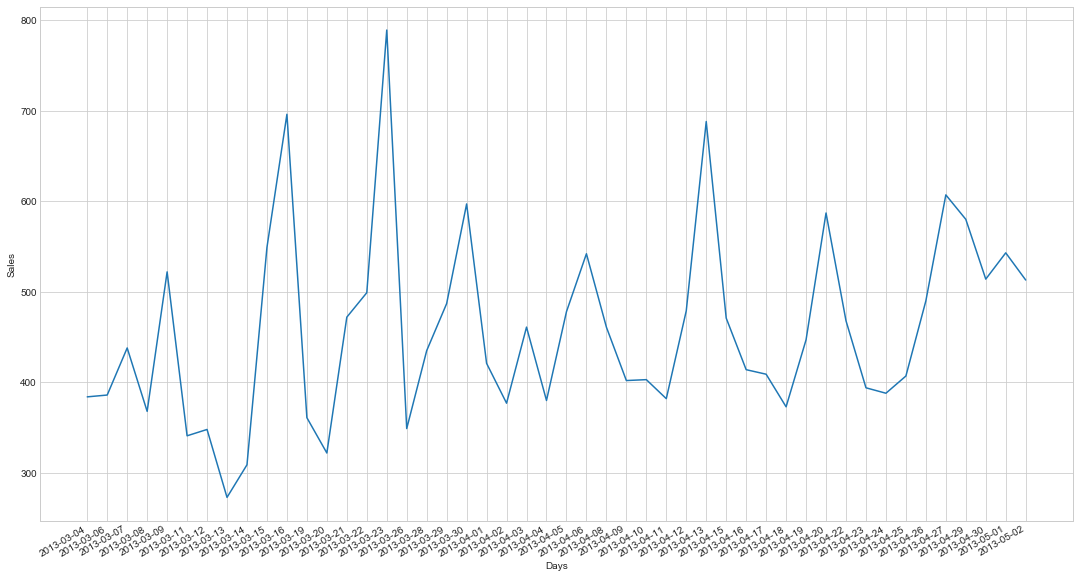

In [145]:
# TO BE DELETED
daysales1 = daysales[daysales.CategoryC==183]
fig, ax = plt.subplots()
fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.plot(daysales1.Date,daysales1.day_sales)
print('ΦΡΕΣΚΑ ΛΑΧΑΝΙΚΑ')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.show()

In [ ]:
# TO BE DELETED
daysales1 = daysales[daysales.CategoryC==183]
fig, ax = plt.subplots()
fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.plot(daysales1.Date,daysales1.day_sales)
print('ΦΡΕΣΚΑ ΛΑΧΑΝΙΚΑ')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.show()